## Setup

In [ ]:
#| code-fold: true
#| code-summary: "pip installs and imports"
!pip install sentence-transformers -Uqq
!pip install -qq RAGatouille
!pip install ftfy -qq

import sqlite3
import json
import re
import os
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import requests
import torch
import torch.nn.functional as F
from ftfy import fix_text
from sentence_transformers import SentenceTransformer
from ragatouille import RAGPretrainedModel
from ragatouille.data import CorpusProcessor

corpus_processor = CorpusProcessor()
emb_model = SentenceTransformer("BAAI/bge-small-en-v1.5")

In [3]:
#| code-fold: true
#| code-summary: "Download chapter ipynb files"
urls = {
    '01_intro.ipynb': 'https://drive.google.com/uc?export=view&id=1mmBjFH_plndPBC4iRZHChfMazgBxKK4_',
    '02_production.ipynb': 'https://drive.google.com/uc?export=view&id=1Cf5QHthHy1z13H0iu3qrzAWgquCfqVHk',
    '04_mnist_basics.ipynb': 'https://drive.google.com/uc?export=view&id=113909_BNulzyLIKUNJHdya0Hhoqie30I',
    '08_collab.ipynb': 'https://drive.google.com/uc?export=view&id=1BtvStgFjUtvtqbSZNrL7Y2N-ey3seNZU',
    '09_tabular.ipynb': 'https://drive.google.com/uc?export=view&id=1rHFvwl_l-AJLg_auPjBpNrOgG9HDnfqg',
    '10_nlp.ipynb': 'https://drive.google.com/uc?export=view&id=1pg1pH7jMMElzrXS0kBBz14aAuDsi2DEP',
    '13_convolutions.ipynb': 'https://drive.google.com/uc?export=view&id=19P-eEHpAO3WrOvdxgXckyhHhfv_R-hnS'
}

def download_file(url, filename):
    # Send a GET request to the URL
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Open the file in write-binary mode
        with open(filename, 'wb') as file:
            # Write the content of the response to the file
            file.write(response.content)
        print(f"File downloaded successfully: {filename}")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")

for fname, url in urls.items():
  download_file(url, fname)

File downloaded successfully: 01_intro.ipynb
File downloaded successfully: 02_production.ipynb
File downloaded successfully: 04_mnist_basics.ipynb
File downloaded successfully: 08_collab.ipynb
File downloaded successfully: 09_tabular.ipynb
File downloaded successfully: 10_nlp.ipynb
File downloaded successfully: 13_convolutions.ipynb


In [ ]:
#| code-fold: true
#| code-summary: "`nbs` dict"
nbs = {
    '1': '01_intro.ipynb',
    '2': '02_production.ipynb',
    '4': '04_mnist_basics.ipynb',
    '8': '08_collab.ipynb',
    '9': '09_tabular.ipynb',
    '10': '10_nlp.ipynb',
    '13': '13_convolutions.ipynb'
}

In [ ]:
#| code-fold: true
#| code-summary: "load questions"
url = 'https://gist.githubusercontent.com/vishalbakshi/2c22ca69ac7bc4bc845052c1b9d949c8/raw/d498259f2fc75d27c485ddc73933f145987feef3/cs_bm25_baselines.csv'
questions = pd.read_csv(url).query("is_answerable == 1")[["chapter", "question_number", "question_text", "answer", "keywords"]]

# remove double quotations from the question text
# as these affect embeddings/cosine similarity: https://vishalbakshi.github.io/blog/posts/2024-11-08-punctuation-cosine-similarity/
questions['question_text'] = questions['question_text'].str.strip('"\'')
assert questions.shape == (191,5)

In [ ]:
#| code-fold: true
#| code-summary: "download fastbook-benchmark"
download_file(
    "https://gist.githubusercontent.com/vishalbakshi/a507b6e9e893475e93a4141e96b8947d/raw/e32835ba1dbf94384943ed5a65404112e1c89df2/fastbook-benchmark.json",
    "fastbook-benchmark.json"
    )

def load_benchmark():
    # Load the benchmark data
    with open('fastbook-benchmark.json', 'r') as f:
        benchmark = json.load(f)
    return benchmark

benchmark = load_benchmark()
assert len(benchmark['questions']) == 191

File downloaded successfully: fastbook-benchmark.json


In [ ]:
#| code-fold: true
#| code-summary: "`calculate_mrr` function"
def calculate_mrr(question, retrieved_passages, cutoff=10):
    retrieved_passages = retrieved_passages[:cutoff]
    highest_rank = 0

    for ans_comp in question["answer_context"]:
        contexts = ans_comp.get("context", [])
        component_found = False

        for rank, passage in enumerate(retrieved_passages, start=1):
            if any(fix_text(context) in fix_text(passage) for context in contexts):
                highest_rank = max(highest_rank, rank)
                component_found = True
                break

        if not component_found:
            return 0.0

    return 1.0/highest_rank if highest_rank > 0 else 0.0

In [ ]:
#| code-fold: true
#| code-summary: "`calculate_recall` function"
def calculate_recall(question, retrieved_passages, cutoff=10):
    retrieved_passages = retrieved_passages[:cutoff]

    # Track if we've found at least one context for each answer component
    ans_comp_found = []

    for ans_comp in question["answer_context"]:
        contexts = ans_comp.get("context", [])
        found = False

        # Check if any context for this answer component appears in retrieved passages
        for passage in retrieved_passages:
            if any(fix_text(context) in fix_text(passage) for context in contexts):
                found = True
                break

        ans_comp_found.append(found)

    # Recall is ratio of answer components with at least one found context
    return sum(ans_comp_found) / len(ans_comp_found)

In [ ]:
#| code-fold: true
#| code-summary: "`load_data` function"
def load_data(chunks, db_path, chapter=1):
    try:
        # create virtual table if database doesn't exist
        if not os.path.exists(db_path):
            with sqlite3.connect(db_path) as conn:
              cur = conn.cursor()
              cur.execute("""
              CREATE VIRTUAL TABLE fastbook_text
              USING FTS5(chapter, text);
              """)
              conn.commit()

        # load in the chunks for each chapter
        with sqlite3.connect(db_path) as conn:
            cur = conn.cursor()

            for chunk in chunks:
                cur.execute("INSERT INTO fastbook_text(chapter, text) VALUES (?, ?)", (chapter, chunk))

            conn.commit()
            res = cur.execute("SELECT * FROM fastbook_text WHERE chapter = ?", (chapter,)).fetchall()
        # make sure all the data was loaded into the database
        if len(res) != len(chunks):
            raise ValueError(f"Number of inserted chunks ({len(res)}) doesn't match input chunks ({len(chunks)})")

        return True

    except sqlite3.Error as e:
        print(f"An error occurred: {e}")
        return False
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return False

In [ ]:
#| code-fold: true
#| code-summary: "`db_search` function"
def db_search(df, limit=1):
  results = []
  with sqlite3.connect('fastbook.db') as conn:
    cur = conn.cursor()
    # concatenate the keywords into a string "keyword1 OR keyword 2 OR keyword3 ..."
    for _, row in df.iterrows():
      keywords = ' OR '.join([f'"{keyword.strip(",")}"' for keyword in row['keywords'].replace('"', '').split()])

      q = f"""
        SELECT text, rank
        FROM fastbook_text
        WHERE fastbook_text MATCH ?
        AND chapter = ?
        ORDER BY rank
        LIMIT ?
        """
      res = cur.execute(q, (keywords, str(row['chapter']), limit)).fetchall()
      # grab the retrieved chunk from the query results
      res = [item[0] for item in res]

      # if there are multiple chunks retrieved, combine them into a single string
      results.append(res)

    return results

In [ ]:
#| code-fold: true
#| code-summary: "`fts_retrieval` function"
def fts_retrieval(data, df, chunk_size):
    if os.path.exists("fastbook.db"):
        os.remove("fastbook.db")

    for chapter, chunks in data.items():
        documents = corpus_processor.process_corpus(chunks, chunk_size=chunk_size)
        documents = [doc['content'] for doc in documents]
        assert load_data(documents, 'fastbook.db', chapter)

    results = db_search(df, limit=10)
    assert len(results) == 191

    for res in results:
        assert len(res) <= 10

    return results

In [ ]:
#| code-fold: true
#| code-summary: "`single_vector_retrieval` function"
def single_vector_retrieval(data, benchmark, chunk_size):
    # Group questions by chapter
    questions = {}
    for q in benchmark["questions"]:
        chapter = str(q["chapter"])
        if chapter not in questions:
            questions[chapter] = []
        questions[chapter].append(q['question_text'].strip('"\''))

    q_embs = {}
    for chapter, _ in data.items():
        qs = questions[chapter]
        q_embs[chapter] = emb_model.encode(qs, convert_to_tensor=True)

    results = []
    for chapter, chunks in data.items():
        # chunk chapter text
        documents = corpus_processor.process_corpus(chunks, chunk_size=chunk_size)
        documents = [doc['content'] for doc in documents]

        # Embed documents
        data_embs = emb_model.encode(documents, convert_to_tensor=True)

        # Compute cosine similarity and get top 10 indices for each row
        idxs = F.cosine_similarity(q_embs[chapter].unsqueeze(1), data_embs.unsqueeze(0), dim=2).sort(descending=True)[1]
        top_10_idxs = idxs[:, :10]  # Get the top 10 indices for each row

        # Extract top 10 chunks for each row
        top_10_chunks = [
            [documents[idx.item()] for idx in row_idxs]
            for row_idxs in top_10_idxs
        ]
        results.extend(top_10_chunks)

    assert len(results) == 191

    for res in results:
        assert len(res) <= 10

    return results

In [ ]:
#| code-fold: true
#| code-summary: "`index_free_retrieval` function"
def index_free_retrieval(data, model_nm, chunk_size, benchmark):
    questions_by_chapter = {}
    for q in benchmark["questions"]:
        chapter = str(q["chapter"])
        if chapter not in questions_by_chapter:
            questions_by_chapter[chapter] = []
        questions_by_chapter[chapter].append(q)

    # Dictionary to store results per chapter
    chapter_results = {}

    # Process each chapter separately
    for chapter in nbs.keys():
        # instantiate new RAG object
        RAG = RAGPretrainedModel.from_pretrained(model_nm)

        # Get questions for this chapter
        chapter_questions = questions_by_chapter[chapter]

        # encode chapter documents
        documents = corpus_processor.process_corpus(data[chapter], chunk_size=chunk_size)
        RAG.encode([x['content'] for x in documents], document_metadatas=[{"chapter": chapter} for _ in range(len(documents))])

        # Perform retrieval for each question in this chapter
        results = []
        for q in chapter_questions:
            top_k = min(10, len(documents))
            retrieved = RAG.search_encoded_docs(query = q["question_text"].strip('"\''), k=top_k)
            results.append(retrieved)

        # Store results
        chapter_results[chapter] = results

    results = []
    for chapter, res in chapter_results.items():
        results.extend(res)

    assert len(results) == 191

    final_results = []
    for res in results:
        assert len(res) <= 10
        intermediate_results = [r['content'] for r in res]
        final_results.append(intermediate_results)

    assert len(final_results) == 191
    return final_results

In [ ]:
#| code-fold: true
#| code-summary: "`do_retrieval` function"
def do_retrieval(method, chunk_size, data, benchmark, questions=None, benchmark_results=None):
  if method == "bm25": results = fts_retrieval(data, questions, chunk_size)
  if method == "single_vector": results = single_vector_retrieval(data, benchmark, chunk_size)
  if method == "colbertv2": results = index_free_retrieval(data=data, model_nm="colbert-ir/colbertv2.0", chunk_size=chunk_size, benchmark=benchmark)
  if method == "answerai_colbert": results = index_free_retrieval(data=data, model_nm="answerdotai/answerai-colbert-small-v1", chunk_size=chunk_size, benchmark=benchmark)

  #name = f"{method}_{chunking_strategy}"
  q_mrr, q_recall = score_retrieval(results, benchmark)
  #benchmark_results = save_results(results, benchmark_results, q_mrr, q_recall, name=name)

  return pd.Series(q_mrr).mean(), pd.Series(q_recall).mean()

In [ ]:
#| code-fold: true
#| code-summary: "`score_retrieval` function"
def score_retrieval(results, benchmark):
    q_mrr = []
    q_recall = []

    for i, question in enumerate(benchmark["questions"]):
        mrr = calculate_mrr(question, results[i], cutoff=10)
        recall = calculate_recall(question, results[i], cutoff=10)
        q_mrr.append(mrr)
        q_recall.append(recall)

    assert len(q_mrr) == len(benchmark["questions"])
    assert len(q_recall) == len(benchmark["questions"])

    return q_mrr, q_recall

In [ ]:
#| code-fold: true
#| code-summary: "`save_results` function"
def save_results(results, df, q_mrr, q_recall, name):
    flat_results = []
    for res in results:
        flat_results.append("\n\n".join(res))

    assert len(flat_results) == 191

    df[f'{name}_retrieval'] = flat_results
    df[f'{name}_mrr10'] = q_mrr
    df[f'{name}_recall10'] = q_recall

    return df

In [ ]:
#| code-fold: true
#| code-summary: "`notebook_to_string` function"
def notebook_to_string(path):
  with open(path, 'r', encoding='utf-8') as f:
    notebook = json.load(f)

  all_text = ''
  found_questionnaire = False

  for cell in notebook['cells']:
    if cell['cell_type'] == 'markdown' and any('## Questionnaire' in line for line in cell['source']):
      found_questionnaire = True
      break

    if cell['cell_type'] in ['markdown', 'code']:
      all_text += ''.join(cell['source']) + '\n'
  return all_text

In [ ]:
#| code-fold: true
#| code-summary: "`chunk_string` function"
def chunk_string(text, n):
    """Split text into n chunks."""
    skip = int(len(text) / n)
    return [text[i:i + skip] for i in range(0, len(text), skip)]

In [ ]:
#| code-fold: true
#| code-summary: "`clean_html` function"
def clean_html(text):
    # Step 1: Temporarily replace double-bracketed content with a placeholder
    import uuid
    placeholder = f"PLACEHOLDER_{uuid.uuid4()}"
    double_bracketed = re.findall(r'<<[^>]*>>', text)
    step1 = re.sub(r'<<[^>]*>>', placeholder, text)

    # Step 2: Remove HTML tags
    step2 = re.sub(r'<[/]?[a-zA-Z][^>]*>', '', step1)

    # Step 3: Restore double-bracketed content
    if double_bracketed:
        step3 = step2.replace(placeholder, double_bracketed[0])
        return step3
    return step2

In [ ]:
#| code-fold: true
#| code-summary: "`remove_punctuation` function"
def remove_punctuation(text):
    import string
    return ''.join(char if char.isalnum() else ' ' if char in string.punctuation else char for char in text)

In [ ]:
#| code-fold: true
#| code-summary: "`process_contexts` function"
def process_contexts(data):
    # Process questions
    for question in data['questions']:
        # Process only answer_context
        if 'answer_context' in question:
            for context_item in question['answer_context']:
                if 'context' in context_item:
                    if isinstance(context_item['context'], list):
                        # If context is a list, process each string in the list
                        context_item['context'] = [
                            remove_punctuation(text) if text else text
                            for text in context_item['context']
                        ]
                    elif isinstance(context_item['context'], str):
                        # If context is a single string, process it directly
                        context_item['context'] = remove_punctuation(context_item['context'])

    return data

## Background

In this notebook, I evaluate four retrieval methods on my fastbook-benchmark dataset using various chunk sizes:

- Full text search (using sqlite and Claude-generated keywords).
- Single-vector cosine similarity (using `SentenceTransformer("BAAI/bge-small-en-v1.5")`).
- ColBERTv2 (using ragatouille).
- answerai-colbert-small-v1 (ragatouille).

For each retrieval method, I'm looking to find the best MRR@10 and Recall@10 for three chunk size ranges:

- Small: 100-500 tokens
- Medium: 500-1000 tokens
- Large: 1000+ tokens

I chose these ranges based on trends I saw during some experiments I ran with ColBERTv2 and answerai-colbert-small-v1 for a chunk size range of 100-3000 tokens.

I'm using `corpus_processor.process_corpus` for chunking.

## Data Preprocessing

For each retrieval method/chunk size combination, I'll preprocess my data three ways:

- No preprocessing.
- Remove HTML tags.
- Remove punctuation.

Note that in each case, I am first converting the `.ipynb` for each chapter into a single string and splitting them into 2-3 chunks since for full-length texts were causing OOM during ColBERTv2 encoding.

In [23]:
#| code-fold: true
#| code-summary: "Prep `no preprocessing` dataset"
data_no_pp = {}
n_chars = 0

for chapter, nb in nbs.items():
    data_no_pp[chapter] = chunk_string(notebook_to_string(nb), 2)
    for c in data_no_pp[chapter]:
        n_chars += len(c)

assert n_chars == 503769

In [24]:
#| code-fold: true
#| code-summary: "Prep `no HTML` dataset"
data_no_html = {}

n_chars = 0
for chapter, nb in nbs.items():
    data_no_html[chapter] = chunk_string(notebook_to_string(nb), 2)
    for c in data_no_html[chapter]:
        n_chars += len(c)

assert n_chars == 503769

n_chars = 0
for chapter, chunks in data_no_html.items():
    data_no_html[chapter] = [clean_html(chunk) for chunk in chunks]
    for string in data_no_html[chapter]: n_chars += len(string)

assert n_chars == 493604

In [25]:
#| code-fold: true
#| code-summary: "Prep `no punctuation` dataset"
data_no_punc = {}

n_chars = 0
for chapter, nb in nbs.items():
    data_no_punc[chapter] = chunk_string(notebook_to_string(nb), 2)
    for c in data_no_punc[chapter]:
        n_chars += len(c)

assert n_chars == 503769

n_chars = 0
for chapter, chunks in data_no_punc.items():
    data_no_punc[chapter] = [remove_punctuation(chunk) for chunk in chunks]
    for string in data_no_punc[chapter]: n_chars += len(string)

# we are replacing punctuation with single space so n_chars doesn't change
assert n_chars == 503769

## Benchmark Dataset

In [26]:
benchmark = load_benchmark()
assert len(benchmark['questions']) == 191

processed_benchmark = process_contexts(benchmark)
assert len(processed_benchmark['questions']) == 191

## Running Retrieval (100-2000 token chunks)

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data: No Preprocessing

In [ ]:
results = []

for method in ["bm25", "single_vector", "colbertv2", "answerai_colbert"]:
  for chunk_size in range(100, 2100, 100):
    mrr, recall = do_retrieval(method, chunk_size, data_no_pp, load_benchmark(), questions)
    results.append(('no preprocessing', method, chunk_size, mrr, recall))

df = pd.DataFrame(results, columns=['data', 'method', 'chunk_size', 'MRR@10', 'Recall@10'])
df.to_csv("/content/drive/MyDrive/2024-11-29-fastbook-benchmark-results_no preprocessing.csv", index=False)

### Data: No HTML Tags

In [ ]:
results = []

for method in ["bm25", "single_vector", "colbertv2", "answerai_colbert"]:
  for chunk_size in range(100, 2100, 100):
    mrr, recall = do_retrieval(method, chunk_size, data_no_html, load_benchmark(), questions)
    results.append(('no HTML', method, chunk_size, mrr, recall))

df = pd.DataFrame(results, columns=['data', 'method', 'chunk_size', 'MRR@10', 'Recall@10'])
df.to_csv("/content/drive/MyDrive/2024-11-29-fastbook-benchmark-results_no HTML.csv", index=False)

### Data: No Punctuation

In [ ]:
results = []

for method in ["bm25", "single_vector", "colbertv2", "answerai_colbert"]:
  for chunk_size in range(100, 2100, 100):
    mrr, recall = do_retrieval(method, chunk_size, data_no_punc, process_contexts(benchmark), questions)
    results.append(('no punctuation', method, chunk_size, mrr, recall))

df = pd.DataFrame(results, columns=['data', 'method', 'chunk_size', 'MRR@10', 'Recall@10'])
df.to_csv("/content/drive/MyDrive/2024-11-29-fastbook-benchmark-results_no punctuation.csv", index=False)

## Analyzing Results

In [195]:
#| code-fold: true
#| code-summary: "Load saved results CSVs"
no_pp = pd.read_csv("/content/drive/MyDrive/2024-11-29-fastbook-benchmark-results_no preprocessing.csv")
no_html = pd.read_csv("/content/drive/MyDrive/2024-11-29-fastbook-benchmark-results_no HTML.csv")
no_punc = pd.read_csv("/content/drive/MyDrive/2024-11-29-fastbook-benchmark-results_no punctuation.csv")
df = pd.concat([no_pp, no_html, no_punc])
df.shape

(240, 5)

### Best Overall MRR@10

Surprisingly, full text search had the highest-overall MRR@10 with 0.67 for 2000-token chunks, for text with punctuation removed.

In [32]:
df[df['MRR@10'] == df['MRR@10'].max()]

,data,method,chunk_size,MRR@10,Recall@10
19,no punctuation,bm25,2000,0.668046,0.94315


### Best Overall Recall@10

Full text search also yielded the best overall Recall@10 at 95%, also at a chunk size of 2000 tokens, but for text with no preprocessing on it (other than splitting the notebook into 2-3 chunks). Wow!

In [33]:
df[df['Recall@10'] == df['Recall@10'].max()]

,data,method,chunk_size,MRR@10,Recall@10
19,no preprocessing,bm25,2000,0.658541,0.95493


### Analyzing Metrics by Chunk Size Range

I care about chunk size because eventually I am going to pass on the retrieved context to an LLM for answer generation and context size will dictate latency and potentially performance.

In [35]:
df['category'] = pd.cut(df['chunk_size'], bins=[100, 500, 1000, 2000], labels=['small', 'medium', 'large'], include_lowest=True)

#### MRR@10

|Chunk Size Category|Retrieval Method|MRR@10|Chunk Size|Dataset|
|:-:|:-:|:-:|:-:|:-:|
|Small (100-500 tokens)|answer-colbert-small-v1|0.59|500 tokens|No punctuation
|Medium (501-1000 tokens)|ColBERTv2|0.61|600 tokens|No punctuation
|Large (1001-2000 tokens)|Full text search|0.67|2000 tokens|No punctuation

Interesting to note:

- 600 tokens was the best-performing chunk size for medium chunks.
- In all three cases, text without punctuation resulted in the best MRR@10.

#### Recall@10

|Chunk Size Category|Retrieval Method|MRR@10|Chunk Size|Data
|:-:|:-:|:-:|:-:|:-:|
|Small (100-500 tokens)|answer-colbert-small-v1|0.88|500 tokens|No punctuation
|Medium (501-1000 tokens)|Full text search|0.92|1000 tokens|No preprocessing
|Large (1001-2000 tokens)|Full text search|0.95|2000 tokens|No preprocessing

Interesting to note:

- The highest chunk size in each range yielded the best MRR@10.
- Text without punctuation worked best for small chunks while unprocessed text worked best for medium and large chunks.

### Visualizing Metrics by Chunk Size and Method

In [162]:
#| code-fold: true
#| code-summary: "Show `plot_metrics` function"
def plot_metrics(df, metric="MRR@10"):
  plt.style.use('seaborn-v0_8-bright')
  fig, axs = plt.subplots(1, 3, figsize=(20, 6))
  colors = ['#268BD2', '#DC322F', '#859900', '#6C71C4']

  for i, dataset in enumerate(['no preprocessing', 'no HTML', 'no punctuation']):
    data_df = df[df['data'] == dataset]

    for j, method in enumerate(sorted(data_df['method'].unique())):
      method_data = data_df[data_df['method'] == method]
      axs[i].plot(method_data['chunk_size'], method_data[metric],
                        linestyle='--', linewidth=2,
                        color=colors[j],
                        label=method)
      #axs[i].scatter(method_data['chunk_size'], method_data[metric], color=colors[j], s=25)

      axs[i].set_xlabel('Chunk Size (Tokens)', fontsize=14)
      axs[i].set_ylabel('Score' if i == 0 else '', fontsize=14)
      axs[i].set_title(dataset.replace('no ', 'No '), fontsize=16, pad=10)
      axs[i].tick_params(axis='both', labelsize=14)
      axs[i].grid(True, alpha=0.8)
      axs[i].set_xlim(50, 2050)
      if metric == 'MRR@10': axs[i].set_ylim(0.15, 0.7)
      else: axs[i].set_ylim(0.4, 1.0)
  handles, labels = axs[0].get_legend_handles_labels()
  fig.legend(handles, labels, loc='right', bbox_to_anchor=(1.03, 0.5), fontsize=18)

  fig.suptitle(f"fastbook-benchmark {metric} by Chunk Size", fontsize=24, y=1.05)
  plt.tight_layout()
  plt.subplots_adjust(right=0.85)
  plt.show()

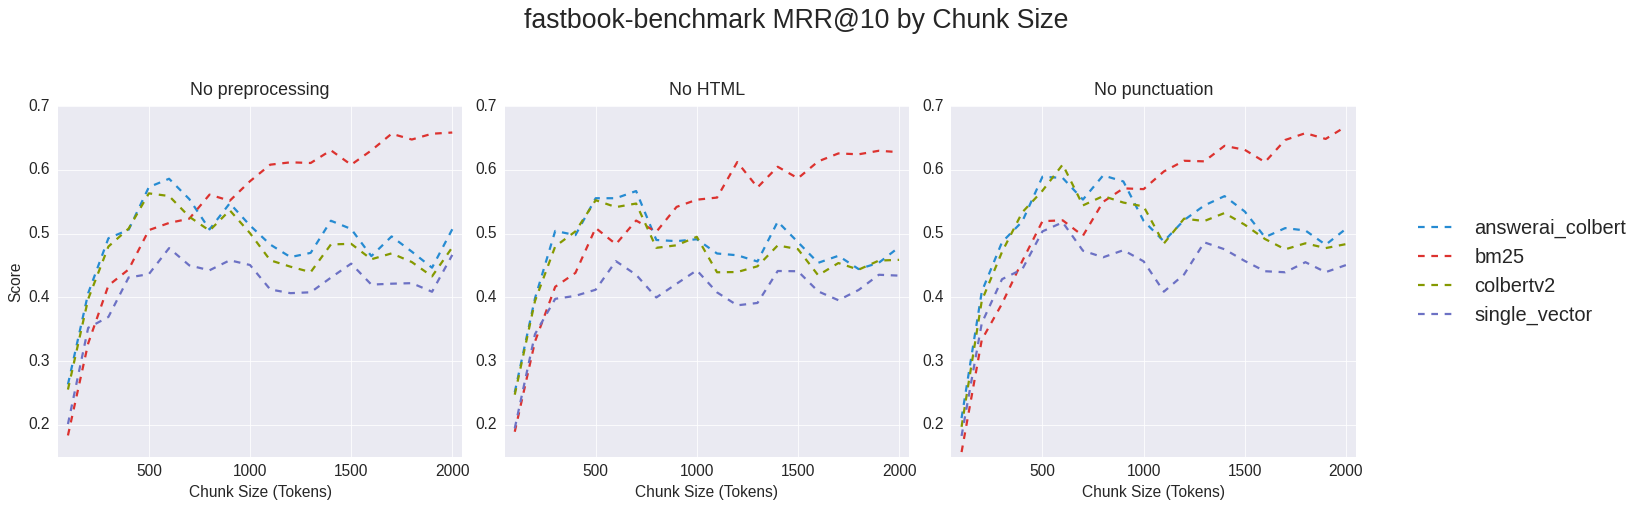

In [163]:
plot_metrics(df)

Takeaways:

- All semantic search methods peak at a chunk size of ~500 tokens.
- Full text search (BM25) mostly monotonically improves with chunk size.
- Single-vector cosine simililarity is the worst-performing method after ~250 tokens.
- For semantic search methods, in general, answerai-colbert-small-v1 > ColBERTv2 > Single-vector cosine similarity.

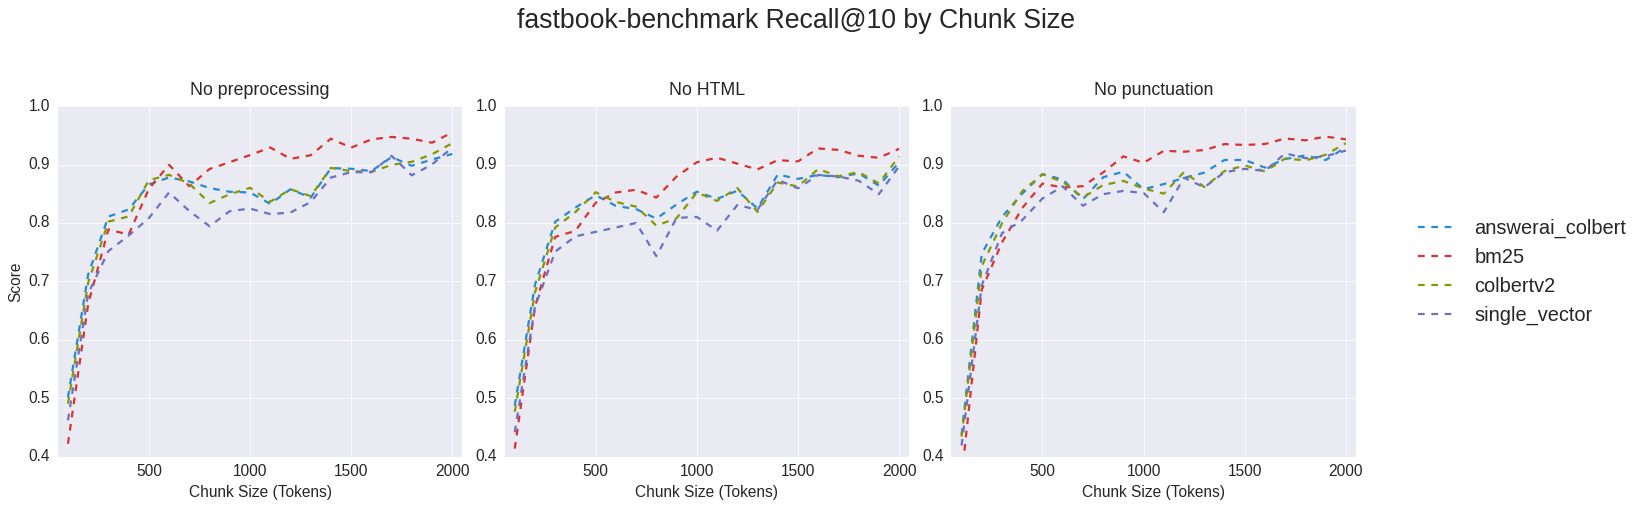

In [164]:
plot_metrics(df, metric="Recall@10")

Takeaways:

- When the data is not preprocessed, all semantic search methods' Recall@10 decreases from ~500 tokens to ~1000 tokens, then increase again to 2000 tokens.
- After 500 tokens, full text search (BM25) has the best Recall@10 for most of the way.

## Final Thoughts

This was an incredibly awesome experience. I did a couple iterations of these experiments before this notebook, each time refactoring my approach so that I could relatively concisely run these chunk size experiments. That process was tough at times but really rewarding.

My three main takeaways:

- For small chunks, answerai-colbert-small-v1 has the best MRR@10 and Recall@10.
- For medium chunks, use ColBERTv2 for the best MRR@10 and full text search for the best Recall@10.
- For large chunks, full text search has the best MRR@10 and Recall@10.

I expect to try out all of these approaches after I integrate an LLM to turn this information retrieval pipeline to a RAG pipeline. My hypothesis is that smaller chunks will yield better responses from the LLM since there will be less "noise" and more "signal" in the context.